In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Install libs

In [2]:
!pip install imutils 
!pip install cython
# Install pycocotools from this GitHub rep
!pip install git+"https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI"

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=ba079f01a3b04ab3e2fd9cbc1be82c8f14a998b4b8da39af3df3f5aea36c36ef
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils
  Cloning https://github.com/philferriere/cocoapi.git to /tmp/pip-req-build-reua49rc
  Running command git clone -q https://github.com/philferriere/cocoapi.git /tmp/pip-req-build-reua49rc
  Resolved https://github.com/philferriere/cocoapi.git to commit 2929bd2ef6b451054755dfd7ceb09278f935f7ad
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=272089 sha256=d842d0b88a8226ca459a252970ce7c1471edd7eb19e1ddabb90e13ce9727e468
  Stored in directory: /tmp/pip-ephem-wheel-cache-xk8m_wvb/wheels/6b/c6/c5/cb6da4cb793a6cb1ab91f6578d76c42686422127eb4dbcea94
Successfully built pycocotools


In [3]:
TOP_PATH = ('/kaggle/input/coco-2017-dataset/coco2017')
TRAIN_PATH = ('/kaggle/input/coco-2017-dataset/coco2017/train2017')
VAL_PATH = ('/kaggle/input/coco-2017-dataset/coco2017/val2017')
ANNOTATIONS_PATH = ('/kaggle/input/coco-2017-dataset/coco2017/annotations')
TEST_PATH = ('/kaggle/input/coco-2017-dataset/coco2017/test2017')
WORKING_DIR = ('/kaggle/working')
MASK_TRAIN_DIR = ('/kaggle/working/mask_train')
MASK_VAL_DIR =('/kaggle/working/mask_val')
MASK_TRAIN_SMOOTH_DIR = ('/kaggle/working/mask_train_smooth')

In [4]:
os.listdir()

['__notebook__.ipynb']

In [5]:
os.chdir(WORKING_DIR)

# Import Libraries

In [6]:
# Import all the libraries
import numpy as np
import cv2
import requests
import os
import imutils
from PIL import Image
from tqdm.notebook import tqdm
########3
from pycocotools import coco, cocoeval, _mask
from pycocotools import mask as maskUtils
from pycocotools.coco import COCO
import skimage.io as io
import random
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

### For visualizing the outputs ###
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from random import shuffle

from PIL import Image 
import sys

from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *


seed = 2019

random.seed = seed
np.random.seed = seed

2021-09-15 12:02:21.160924: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# Dataset Processing

In [7]:
os.listdir(ANNOTATIONS_PATH)

['person_keypoints_train2017.json',
 'instances_val2017.json',
 'instances_train2017.json',
 'person_keypoints_val2017.json',
 'captions_train2017.json',
 'captions_val2017.json']

In [8]:
ANNOTATION_FILE_VAL = (ANNOTATIONS_PATH + '/instances_val2017.json')
ANNOTATION_FILE_TRAIN = (ANNOTATIONS_PATH + '/instances_train2017.json')

In [9]:
coco_train = COCO(ANNOTATION_FILE_TRAIN)
catIds_train = coco_train.getCatIds()
imgIds_train = coco_train.getImgIds()
imgDict_train = coco_train.loadImgs(imgIds_train)
print(len(imgIds_train) , len(catIds_train))

loading annotations into memory...
Done (t=24.54s)
creating index...
index created!
118287 80


In [10]:
coco_val = COCO(ANNOTATION_FILE_VAL)
catIds_val = coco_val.getCatIds()
imgIds_val = coco_val.getImgIds()
imgDict_val = coco_val.loadImgs(imgIds_val)
print(len(imgIds_val) , len(catIds_val))

loading annotations into memory...
Done (t=1.43s)
creating index...
index created!
5000 80


In [11]:
shuffle(imgIds_train)
shuffle(imgIds_val)

#take less samples
imgIds_train = imgIds_train[0:10000]
imgIds_val = imgIds_val[0:1000]

In [12]:
train_images = ["COCO_train2014_{0:012d}.jpg".format(ids) for ids in imgIds_train]
val_images = ["COCO_val2014_{0:012d}.jpg".format(ids) for ids in imgIds_val]
print(len(train_images) , len(val_images))

10000 1000


In [13]:
os.chdir(WORKING_DIR)

In [14]:
!mkdir mask_train

In [15]:
count = 0 
unfitted_image_dict = []
for ID in tqdm(imgIds_train):
    file_path = MASK_TRAIN_DIR+"/{0:012d}.jpg".format(ID)

    sampleImgIds = coco_train.getImgIds(imgIds = [ID])
    sampleImgDict = coco_train.loadImgs(sampleImgIds[np.random.randint(0,len(sampleImgIds))])[0]

    annIds = coco_train.getAnnIds(imgIds=sampleImgDict['id'], 
                                catIds=catIds_train, 
                                iscrowd=0)
    anns = coco_train.loadAnns(annIds)

    if len(anns)==0:
        unfitted_image_dict.append(sampleImgDict)
    else:
        mask = coco_train.annToMask(anns[0])

        for i in (range(len(anns))):
            mask = mask | coco_train.annToMask(anns[i])
        mask = Image.fromarray(mask * 255 , mode = "L")
        mask.save(file_path)
        count = count + 1
print(count)

  0%|          | 0/10000 [00:00<?, ?it/s]

9905


In [16]:
os.chdir(WORKING_DIR)

In [17]:
!mkdir mask_val

In [18]:
count = 0 
unfitted_image_dict = []
for ID in tqdm(imgIds_val):
    file_path = MASK_VAL_DIR+"/{0:012d}.jpg".format(ID)

    sampleImgIds = coco_val.getImgIds(imgIds = [ID])
    sampleImgDict = coco_val.loadImgs(sampleImgIds[np.random.randint(0,len(sampleImgIds))])[0]

    annIds = coco_val.getAnnIds(imgIds=sampleImgDict['id'], 
                                catIds=catIds_val, 
                                iscrowd=0)
    anns = coco_val.loadAnns(annIds)

    if len(anns)==0:
        unfitted_image_dict.append(sampleImgDict)
    else:
        mask = coco_val.annToMask(anns[0])

        for i in (range(len(anns))):
            mask = mask | coco_val.annToMask(anns[i])
        mask = Image.fromarray(mask * 255 , mode = "L")
        mask.save(file_path)
        count = count + 1
print(count)

  0%|          | 0/1000 [00:00<?, ?it/s]

991


In [19]:
os.chdir(WORKING_DIR)

In [20]:
os.chdir('mask_val')

In [21]:
cv2.imread(os.listdir()[0])

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

# Trimap Generator

In [22]:
#train_mask_list = os.listdir(MASK_TRAIN_DIR)

In [23]:
#train_list = os.listdir(TRAIN_PATH)

In [24]:
#os.chdir(MASK_TRAIN_DIR)

In [25]:
#!mkdir mask_train_smooth

In [26]:
#os.listdir()

In [27]:
#from pylab import rcParams
#rcParams['figure.figsize'] = 50, 20

In [28]:
# pre-process the masks and generate tri-maps
'''for i in tqdm(train_mask_list):
    path = MASK_TRAIN_SMOOTH_DIR + "/"+str(i)
  

    # use the created array to output your multiple images. In this case I have stacked 4 images vertically
    og_mask=(cv2.imread(i))
    og_mask = cv2.cvtColor(og_mask, cv2.COLOR_BGR2GRAY)
    eroded_mask = cv2.erode(og_mask,None,iterations=6)
    dilated_mask = cv2.dilate(eroded_mask,None,iterations=10)
    copied_mask = np.copy(dilated_mask)
    copied_mask[(dilated_mask!=0)] = 127
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    (thresh, binRed) = cv2.threshold(copied_mask, 128, 255, cv2.THRESH_BINARY)
    copied_mask = cv2.morphologyEx(copied_mask, cv2.MORPH_OPEN, kernel, iterations=3)
    new_mask = og_mask | copied_mask
    new_mask = Image.fromarray(new_mask)
    A = cv2.imread(TRAIN_PATH+"/"+i)
    original_masked = cv2.bitwise_and(A,A,mask = og_mask)
    composite1 = cv2.bitwise_and(A,A,mask = eroded_mask)
    composite2 = cv2.bitwise_and(A,A,mask = copied_mask)
    #trimask = A*new_mask/255
    f, axarr = plt.subplots(5,1)
    axarr[0].imshow(original_masked)
    axarr[1].imshow(composite1)
    axarr[2].imshow(composite2)
    axarr[3].imshow(A)
    axarr[4].imshow(new_mask,cmap='gray')
    break
    #new_mask.save(path)'''

'for i in tqdm(train_mask_list):\n    path = MASK_TRAIN_SMOOTH_DIR + "/"+str(i)\n  \n\n    # use the created array to output your multiple images. In this case I have stacked 4 images vertically\n    og_mask=(cv2.imread(i))\n    og_mask = cv2.cvtColor(og_mask, cv2.COLOR_BGR2GRAY)\n    eroded_mask = cv2.erode(og_mask,None,iterations=6)\n    dilated_mask = cv2.dilate(eroded_mask,None,iterations=10)\n    copied_mask = np.copy(dilated_mask)\n    copied_mask[(dilated_mask!=0)] = 127\n    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))\n    (thresh, binRed) = cv2.threshold(copied_mask, 128, 255, cv2.THRESH_BINARY)\n    copied_mask = cv2.morphologyEx(copied_mask, cv2.MORPH_OPEN, kernel, iterations=3)\n    new_mask = og_mask | copied_mask\n    new_mask = Image.fromarray(new_mask)\n    A = cv2.imread(TRAIN_PATH+"/"+i)\n    original_masked = cv2.bitwise_and(A,A,mask = og_mask)\n    composite1 = cv2.bitwise_and(A,A,mask = eroded_mask)\n    composite2 = cv2.bitwise_and(A,A,mask = c

In [29]:
os.chdir(WORKING_DIR)

In [30]:
os.listdir()

['mask_val', '__notebook__.ipynb', 'mask_train']

# Data Loader

In [31]:
class DataGen(keras.utils.Sequence):
    def __init__(self , path_input , path_mask , batch_size = 8 , image_size = 128):
        self.ids = os.listdir(path_mask) # only take those images that we have segregated masks of
        self.path_input = path_input
        self.path_mask = path_mask
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self , id_name):
        image_path = os.path.join(self.path_input , id_name)
        mask_path = os.path.join(self.path_mask , id_name)
        image = cv2.imread(image_path , 1) # 1 specifies RGB format
        image = cv2.resize(image , (self.image_size , self.image_size)) # resizing before inserting to the network
        mask = cv2.imread(mask_path , -1)
        mask = cv2.resize(mask , (self.image_size , self.image_size))
        mask = mask.reshape((self.image_size , self.image_size , 1))
        #normalize image
        image = image / 255.0
        mask = mask / 255.0
        return image , mask
    
    def __getitem__(self , index):
        if (index + 1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index * self.batch_size
        file_batch = self.ids[index * self.batch_size : (index + 1) * self.batch_size]
        images = []
        masks = []
        
        for id_name in file_batch : 
            _img , _mask = self.__load__(id_name)
            images.append(_img)
            masks.append(_mask)
        
        images = np.array(images)
        masks = np.array(masks)
        return images , masks
    
    def on_epoch_end(self):
        pass
    def __len__(self):
        return int(np.ceil(len(self.ids) / float(self.batch_size)))

In [32]:
image_size = 128 
epochs = 10
batch_size = 10

In [33]:
train_gen = DataGen(path_input = TRAIN_PATH , path_mask = MASK_TRAIN_DIR , batch_size = batch_size , image_size = image_size)
val_gen = DataGen(path_input =  VAL_PATH, path_mask =  MASK_VAL_DIR, batch_size = batch_size , image_size = image_size)

In [34]:
x, y = train_gen.__getitem__(6)

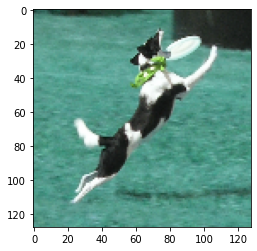

In [35]:
plt.imshow(x[0]) # just an example to show that the dataloader is working fine

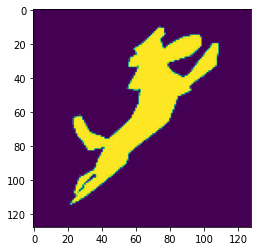

In [36]:
plt.imshow(y[0])

# Start Making a UNet like Model

In [37]:
def down_block(
    input_tensor,no_filters,kernel_size=(3, 3),
    strides=(1, 1),padding="same",kernel_initializer="he_normal",
    max_pool_window=(2, 2),max_pool_stride=(2, 2)):
    conv = Conv2D(filters=no_filters,kernel_size=kernel_size,
                  strides=strides,activation=None,
                  padding=padding,kernel_initializer=kernel_initializer)(input_tensor)
    conv = BatchNormalization(scale=True)(conv)
    conv = Activation("relu")(conv)
    conv = Conv2D(filters=no_filters,kernel_size=kernel_size,
                  strides=strides,activation=None,
                  padding=padding,kernel_initializer=kernel_initializer)(conv)
    conv = BatchNormalization(scale=True)(conv)
    # conv for skip connection
    conv = Activation("relu")(conv)
    pool = MaxPooling2D(pool_size=max_pool_window, strides=max_pool_stride)(conv)
    return conv, pool

In [38]:
def bottle_neck(input_tensor,no_filters,kernel_size=(3, 3),
    strides=(1, 1),padding="same",kernel_initializer="he_normal"):
    conv = Conv2D(filters=no_filters,kernel_size=kernel_size,
                  strides=strides,activation=None,padding=padding,
                  kernel_initializer=kernel_initializer)(input_tensor)
    conv = BatchNormalization(scale=True)(conv)
    conv = Activation("relu")(conv)
    conv = Conv2D(filters=no_filters,kernel_size=kernel_size,
                  strides=strides,activation=None,padding=padding,
                  kernel_initializer=kernel_initializer)(conv)
    conv = BatchNormalization(scale=True)(conv)
    conv = Activation("relu")(conv)
    return conv

In [39]:
def up_block(input_tensor,no_filters,skip_connection, 
             kernel_size=(3, 3),strides=(1, 1),upsampling_factor = (2,2),
             max_pool_window = (2,2),padding="same",kernel_initializer="he_normal"):
    conv = Conv2D(filters = no_filters,kernel_size= max_pool_window,
                  strides = strides,activation = None,padding = padding,
                  kernel_initializer=kernel_initializer)(UpSampling2D(size = upsampling_factor)(input_tensor))
    conv = BatchNormalization(scale=True)(conv)
    conv = Activation("relu")(conv) 
    conv = concatenate( [skip_connection , conv]  , axis = -1)
    conv = Conv2D(filters=no_filters,kernel_size=kernel_size,
                  strides=strides,activation=None,padding=padding,
                  kernel_initializer=kernel_initializer)(conv)
    conv = BatchNormalization(scale=True)(conv)
    conv = Activation("relu")(conv)
    conv = Conv2D(filters=no_filters,kernel_size=kernel_size,strides=strides,
                  activation=None,padding=padding,kernel_initializer=kernel_initializer)(conv)
    conv = BatchNormalization(scale=True)(conv)
    conv = Activation("relu")(conv)
    return conv

In [40]:
def output_block(input_tensor,
    padding="same",
    kernel_initializer="he_normal"):
    conv = Conv2D(filters=2,kernel_size=(3,3),strides=(1,1),
                  activation="relu",padding=padding,kernel_initializer=kernel_initializer)(input_tensor)
    conv = Conv2D(filters=1,kernel_size=(1,1),strides=(1,1),
        activation="sigmoid",padding=padding,kernel_initializer=kernel_initializer)(conv)
    return conv

In [41]:
def UNet(input_shape = (128,128,3)):
    filter_size = [64,128,256,512,1024]
    inputs = keras.Input(shape = input_shape)
    
    d1 , p1 = down_block(input_tensor= inputs,no_filters=filter_size[0],
                         kernel_size = (3,3),strides=(1,1),
                         padding="same",kernel_initializer="he_normal",
                         max_pool_window=(2,2),max_pool_stride=(2,2))
    d2 , p2 = down_block(input_tensor= p1,no_filters=filter_size[1],
                         kernel_size = (3,3),strides=(1,1),
                         padding="same", kernel_initializer="he_normal",
                         max_pool_window=(2,2),max_pool_stride=(2,2))  
    d3 , p3 = down_block(input_tensor= p2, no_filters=filter_size[2],
                         kernel_size = (3,3),strides=(1,1),
                         padding="same", kernel_initializer="he_normal",
                         max_pool_window=(2,2), max_pool_stride=(2,2))
    d4 , p4 = down_block(input_tensor= p3, no_filters=filter_size[3],
                         kernel_size = (3,3), strides=(1,1),
                         padding="same",kernel_initializer="he_normal",
                         max_pool_window=(2,2), max_pool_stride=(2,2))

    b = bottle_neck(input_tensor= p4, no_filters=filter_size[4],
                         kernel_size = (3,3), strides=(1,1),
                         padding="same", kernel_initializer="he_normal")
    
    
    u4 = up_block(input_tensor = b, no_filters = filter_size[3],
                  skip_connection = d4,kernel_size=(3, 3),
                  strides=(1, 1),upsampling_factor = (2,2),
                  max_pool_window = (2,2), padding="same",kernel_initializer="he_normal")
    u3 = up_block(input_tensor = u4,no_filters = filter_size[2],
                  skip_connection = d3, kernel_size=(3, 3),
                  strides=(1, 1),upsampling_factor = (2,2),
                  max_pool_window = (2,2),padding="same",kernel_initializer="he_normal")
    u2 = up_block(input_tensor = u3, no_filters = filter_size[1],
                  skip_connection = d2,kernel_size=(3, 3),
                  strides=(1, 1), upsampling_factor = (2,2),
                  max_pool_window = (2,2),padding="same", kernel_initializer="he_normal")
    u1 = up_block(input_tensor = u2,no_filters = filter_size[0],
                  skip_connection = d1,kernel_size=(3, 3),
                  strides=(1, 1), upsampling_factor = (2,2),
                  max_pool_window = (2,2), padding="same",kernel_initializer="he_normal")
    
    output = output_block(input_tensor=u1 , padding = "same",kernel_initializer= "he_normal")
    model = Model(inputs = inputs , outputs = output)
    return model

In [42]:
model = UNet(input_shape = (128,128,3))
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

2021-09-15 12:04:07.027714: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-15 12:04:07.031059: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-15 12:04:07.069085: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-15 12:04:07.069739: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-15 12:04:07.069813: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-15 12:04:07.106558: I tensorflow/stream_executor/platform/def

In [43]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [44]:
train_steps =  len(os.listdir(MASK_TRAIN_DIR))/batch_size


model.fit_generator(train_gen , validation_data = val_gen , steps_per_epoch = train_steps , epochs=epochs)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-09-15 12:04:09.939853: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-15 12:04:09.944095: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000189999 Hz


Epoch 1/10


2021-09-15 12:04:12.495898: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2021-09-15 12:04:17.908060: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-15 12:04:18.661839: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


990/990 [==============================] - 186s 178ms/step - loss: 0.5554 - accuracy: 0.7111 - val_loss: 0.4600 - val_accuracy: 0.7433
Epoch 2/10
990/990 [==============================] - 81s 81ms/step - loss: 0.4757 - accuracy: 0.7374 - val_loss: 0.5060 - val_accuracy: 0.7355
Epoch 3/10
990/990 [==============================] - 77s 78ms/step - loss: 0.4534 - accuracy: 0.7527 - val_loss: 0.4347 - val_accuracy: 0.7658
Epoch 4/10
990/990 [==============================] - 74s 75ms/step - loss: 0.4353 - accuracy: 0.7653 - val_loss: 0.4520 - val_accuracy: 0.7592
Epoch 5/10
990/990 [==============================] - 74s 75ms/step - loss: 0.4197 - accuracy: 0.7716 - val_loss: 0.4265 - val_accuracy: 0.7650
Epoch 6/10
990/990 [==============================] - 74s 75ms/step - loss: 0.4119 - accuracy: 0.7791 - val_loss: 0.4309 - val_accuracy: 0.7590
Epoch 7/10
990/990 [==============================] - 73s 74ms/step - loss: 0.3988 - accuracy: 0.7814 - val_loss: 0.3960 - val_accuracy: 0.7896
E

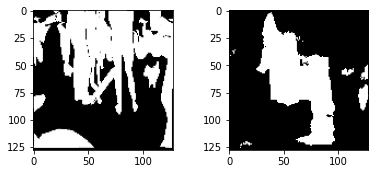

In [45]:
x, y = val_gen.__getitem__(12)
result = model.predict(x)

result = result > 0.5

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")